# Question 1: How do Airbnb rates differ across listings from Berlin?
The first question around the Airbnb Berlin data set is about the differences of rates per night and person for Airbnb homes in the city. The steps involved in answering the question are as follows:
* Load Libraries
* Import Data Set
* Pre-Processing
* Analyze Data Set & Evaluate Results

## Load Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import folium

%matplotlib inline

## Import Data Set

In [2]:
# Import listings data
df_listings = pd.read_csv('/Users/patrick.peltier/Documents/Udacity Data Science Nanodegree/Data/Airbnb/listings_berlin.csv')

# Preview data
print(df_listings.shape)
pd.options.display.max_columns = None
df_listings.head(1)

(22572, 96)


id                        listing_url       scrape_id last_scraped  \
0  2015  https://www.airbnb.com/rooms/2015  20180912025131   2018-09-12   

                                               name  \
0  Berlin-Mitte Value! Quiet courtyard/very central   

                                             summary  \
0  Great location!  30 of 75 sq meters. This wood...   

                                               space  \
0  A+++ location! This „Einliegerwohnung“ is an e...   

                                         description experiences_offered  \
0  Great location!  30 of 75 sq meters. This wood...                none   

                               neighborhood_overview  \
0  It is located in the former East Berlin area o...   

                                               notes  \
0  This is my home, not a hotel. I rent out occas...   

                                             transit  \
0  Close to U-Bahn U8 and U2 (metro), Trams M12, ...   

                                              access       interaction  \
0  Simple kitchen/cooking, refrigerator, microwav...  Always available   

                                         house_rules  thumbnail_url  \
0  No parties No events No pets No smoking, not e...            NaN   

   medium_url                                        picture_url  \
0         NaN  https://a0.muscache.com/im/pictures/260fd609-7...   

   xl_picture_url  host_id                                host_url host_name  \
0             NaN     2217  https://www.airbnb.com/users/show/2217       Ian   

   host_since                         host_location  \
0  2008-08-18  Key Biscayne, Florida, United States   

                    host_about host_response_time host_response_rate  \
0  Believe in sharing economy.     within an hour               100%   

   host_acceptance_rate host_is_superhost  \
0                   NaN                 t   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/im/pictures/21428a22-4...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/21428a22-4...              Mitte   

   host_listings_count  host_total_listings_count  \
0                  3.0                        3.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    t   

  host_identity_verified                   street neighbourhood  \
0                      t  Berlin, Berlin, Germany         Mitte   

  neighbourhood_cleansed neighbourhood_group_cleansed    city   state zipcode  \
0        Brunnenstr. Süd                        Mitte  Berlin  Berlin   10119   

   market   smart_location country_code  country   latitude  longitude  \
0  Berlin  Berlin, Germany           DE  Germany  52.534537  13.402557   

  is_location_exact property_type        room_type  accommodates  bathrooms  \
0                 f    Guesthouse  Entire home/apt             3        1.0   

   bedrooms  beds  bed_type  \
0       1.0   2.0  Real Bed   

                                           amenities  square_feet   price  \
0  {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...          NaN  $60.00   

  weekly_price monthly_price security_deposit cleaning_fee  guests_included  \
0          NaN           NaN          $200.00       $30.00                1   

  extra_people  minimum_nights  maximum_nights calendar_updated  \
0       $28.00               4            1125      6 weeks ago   

  has_availability  availability_30  availability_60  availability_90  \
0                t                5               34               64   

   availability_365 calendar_last_scraped  number_of_reviews first_review  \
0               154            2018-09-12                109   2016-04-11   

  last_review  review_scores_rating  review_scores_accuracy  \
0  2018-09-08                  92.0                     9.0   

   review_score

## Pre-Processing

First of all, I am going to pre-process the data for the analysis as especially __columns including price information are encoded es objects__. In addition to this I introduce an __adjusted price variable__ as the current variable "price" doesn't consider cleaning fees or rates for additional guest. However, even though Berlin Airbnb homes can accommodate multiple guests most of the time, they only include one in their price. Before creating the new metric I have to __remove rows where the number of guests included is greater than the number of guest that can be accommodated__. I assume that these records contain false information.

In [3]:
# Convert columns representing monetary data to float and impute missing values with 0
price_cols = ["price","weekly_price","monthly_price","security_deposit","cleaning_fee","extra_people"]

for col in price_cols:
    df_listings[col] = df_listings[col].astype(str)
    df_listings[col] = df_listings[col].apply(lambda x: x.replace('$','').replace(',',''))
    df_listings[col] = df_listings[col].astype(float)
    df_listings[col] = df_listings[col].fillna(0)

In [4]:
# Remove all records where "accommodates" < "guest_included" as this shouldn't be possible
print(df_listings.shape[0])
df_listings = df_listings[df_listings["accommodates"] >= df_listings["guests_included"]]
print(df_listings.shape[0])

22572
22466


In [5]:
# Create "price_per_person" column (based on total number of possible guests)
df_listings["price_per_person"] = ((
    df_listings["price"] + df_listings["cleaning_fee"] +
    df_listings["extra_people"] * (df_listings["accommodates"] - df_listings["guests_included"]))
    /
    df_listings["guests_included"])

## Analyses

Let's start by looking a simple summary statistics of Airbnb listing prices per night.

In [6]:
# Summary statistics
# Price
df_listings["price"].describe()

count    22466.000000
mean        65.197766
std        205.244492
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

In [7]:
# Price per person
df_listings["price_per_person"].describe()

count    22466.000000
mean        74.998305
std        159.188371
min          6.000000
25%         38.333333
50%         56.000000
75%         85.000000
max      11000.000000
Name: price_per_person, dtype: float64

Only from looking at the summary statistics we can already see that some hosts in Berlin seem to rent out their places almost for free while others seem to charge prices way beyond average. The introduction of __"price_per_person" shows that none of the offered places comes completely free of charge__ as at least cleaning fees and extra people lead to some sort of costs (compare min values for "price" and "price_per_person").

Let's __compare prices between property types__. Maybe this helps to identify reasons for observing such a large range of listing prices. Also, in order to get a feeling of how each property type may influence the average price I will plot the __frequency of each property type__ within the data set.

In [8]:
# Property type counts
counts_properties = df_listings[["property_type"]]
counts_properties = counts_properties.groupby("property_type").size().reset_index(name="counts")

In [9]:
# Median price / property type
prices_properties = df_listings[["property_type", "price_per_person"]]
prices_properties = prices_properties.groupby("property_type", as_index=False).median()

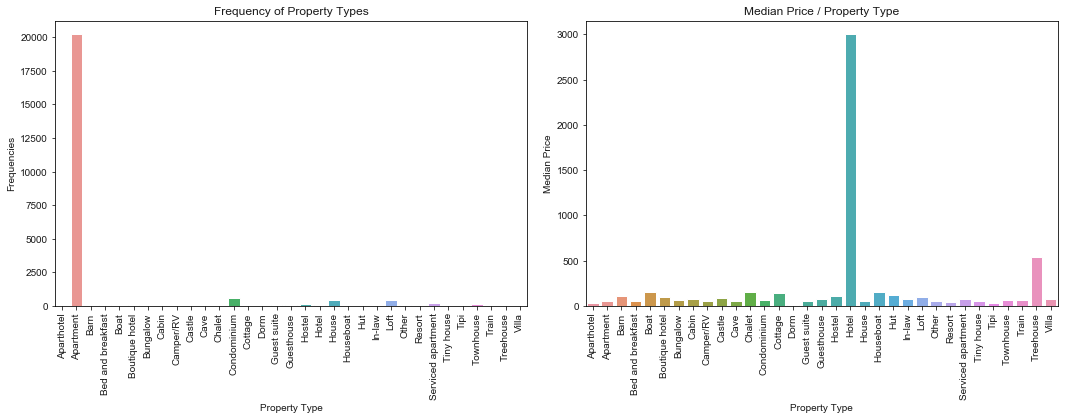

In [10]:
# Plot both charts next to each other
fig, ax = plt.subplots(1,2, figsize = (15,6))
sns.set(style = "darkgrid")
sns.barplot(x="property_type", y="counts", data=counts_properties, ax = ax[0])
sns.barplot(x="property_type", y="price_per_person", data=prices_properties, ax = ax[1])
ax[0].set_ylabel("Frequencies")
ax[0].set_xlabel("Property Type")
ax[0].set_title("Frequency of Property Types")
ax[1].set_ylabel("Median Price")
ax[1].set_xlabel("Property Type")
ax[1].set_title("Median Price / Property Type")
plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()

What's clearly visible is that the different Airbnb property types are everything else but evenly distributed across Berlin. More than __90% of all property types are actually apartments__. When looking at median prices for each property type it's pretty obvious that __hotels are the main reason for the large spread__ of listing prices of Airbnb homes Berlin. As I'd like to __focus on privately offered accommodations__, I'm going to continue with deep dive into apartment prices from here on. I will also try to __remove outliers__ from the analysis, thus remove records where "price_per_person" is greater than the columns 0.99 percentile.

In [11]:
# Keep only apartments in analysis
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["property_type"] == "Apartment"]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

# Remove outliers
n_all = df_listings.shape[0]
df_listings = df_listings[df_listings["price_per_person"] <= df_listings["price_per_person"].quantile(.99)]
print("{} records were removed from the Airbnb Berlin listings data frame.".format(n_all - df_listings.shape[0]))

2244 records were removed from the Airbnb Berlin listings data frame.
200 records were removed from the Airbnb Berlin listings data frame.


Let's see what our __distribution of prices per person__ now looks like.

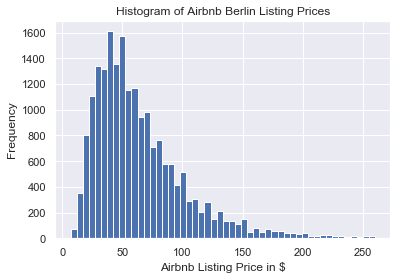

In [12]:
# Histogram
df_listings["price_per_person"].hist(bins=50)
plt.xlabel("Airbnb Listing Price in $")
plt.ylabel("Frequency")
plt.title("Histogram of Airbnb Berlin Listing Prices");

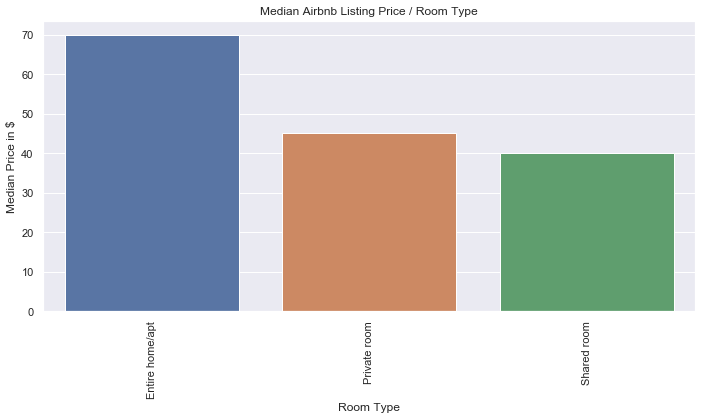

In [13]:
# Average rate / room type
prices_roomtypes = df_listings[["room_type", "price_per_person"]]
prices_roomtypes = prices_roomtypes.groupby("room_type", as_index=False).median()

# Plot
plt.subplots(figsize = (10,6))
sns.set(style="darkgrid")
ax = sns.barplot(x="room_type", y="price_per_person", data=prices_roomtypes)
plt.xticks(rotation=90);
plt.title("Median Airbnb Listing Price / Room Type")
plt.ylabel("Median Price in $")
plt.xlabel("Room Type")
plt.tight_layout()

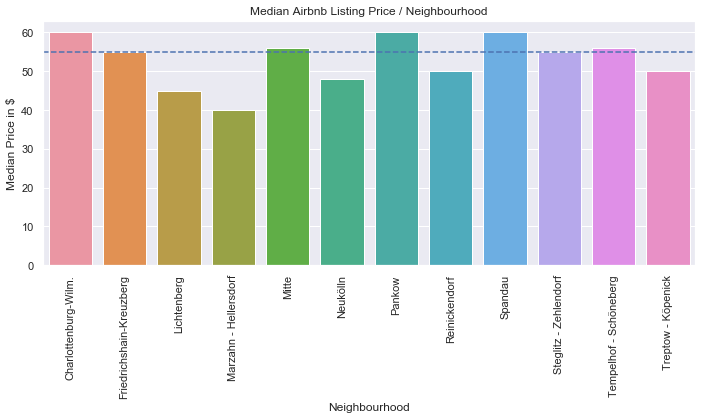

In [14]:
# Maybe use two plots next to each other?!
# Median rate / neighbourhood
prices_neighbourhood = df_listings[["neighbourhood_group_cleansed", "price_per_person"]]
prices_neighbourhood_median = prices_neighbourhood["price_per_person"].median()
prices_neighbourhood = prices_neighbourhood.groupby("neighbourhood_group_cleansed", as_index=False).median()

# Plot
plt.subplots(figsize=(10,6))
sns.set(style="darkgrid")
ax = sns.barplot(x="neighbourhood_group_cleansed", y="price_per_person", data=prices_neighbourhood)
plt.xticks(rotation=90);
plt.title("Median Airbnb Listing Price / Neighbourhood")
plt.ylabel("Median Price in $")
plt.xlabel("Neighbourhood")
plt.tight_layout()

# Add median as reference line
ax.axhline(prices_neighbourhood_median, ls='--');

In [15]:
# Combine the two plots from above to one
prices_neighbourhood_roomtype = df_listings[["neighbourhood_group_cleansed","room_type", "price"]]
prices_neighbourhood_roomtype = prices_neighbourhood_roomtype.groupby(["neighbourhood_group_cleansed","room_type"], as_index=False).median()
prices_neighbourhood_roomtype.head()

neighbourhood_group_cleansed        room_type  price
0         Charlottenburg-Wilm.  Entire home/apt   60.0
1         Charlottenburg-Wilm.     Private room   33.0
2         Charlottenburg-Wilm.      Shared room   25.0
3     Friedrichshain-Kreuzberg  Entire home/apt   65.0
4     Friedrichshain-Kreuzberg     Private room   35.0

/Users/patrick.peltier/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


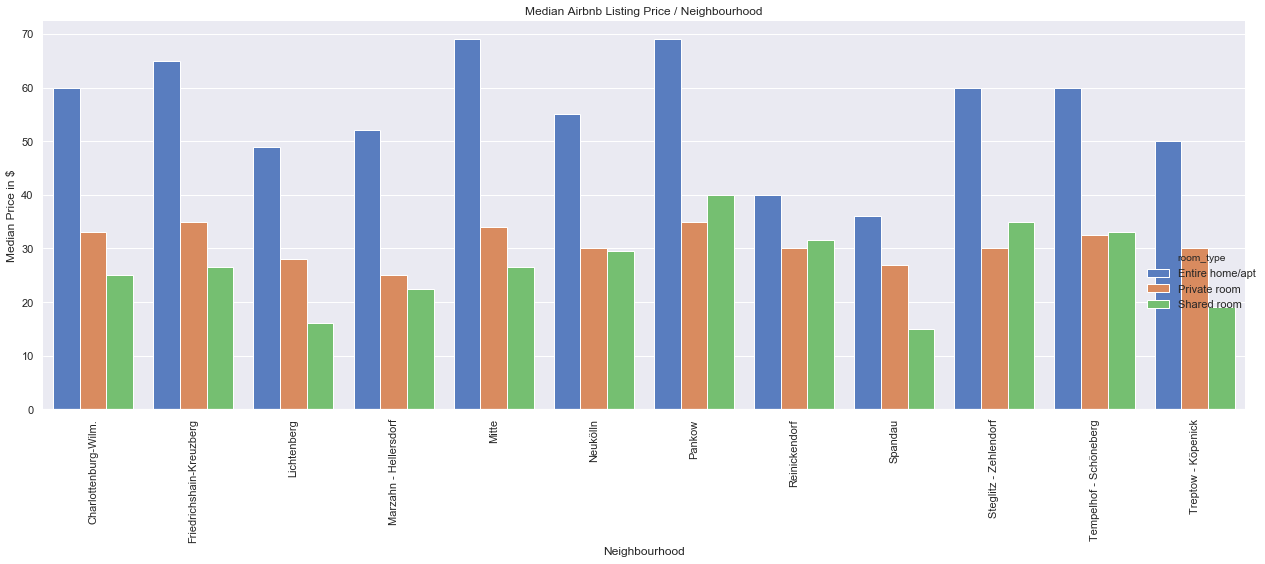

In [16]:
# Plot
#plt.subplots(figsize=(25,20))
sns.set(style='darkgrid', context='notebook')
ax = sns.factorplot(x="neighbourhood_group_cleansed", y="price", hue="room_type", data=prices_neighbourhood_roomtype,
                    height=8, aspect=2, kind="bar", palette="muted")
ax.despine(left=True)
plt.xticks(rotation=90)
plt.title("Median Airbnb Listing Price / Neighbourhood")
plt.ylabel("Median Price in $")
plt.xlabel("Neighbourhood")
plt.tight_layout()

We can even try to go down on to a more granular level and look at zipcode areas.

In [17]:
# Load geojson object
berlin_zip = os.path.join('berlin_zipcode.geojson')
geo_json_data = json.load(open(berlin_zip))

# Source
# https://github.com/funkeinteraktiv/Berlin-Geodaten

In [18]:
# Add "key" column to data frame
df_listings["zipcode_key"] = "re_postleit." + df_listings["zipcode"].astype(str)

# Create price dictionary
price_dict = df_listings[["zipcode_key", "price_per_person"]].set_index("zipcode_key")["price_per_person"]
price_dict["re_postleit.10117"][:5]

re_postleit.10117     75.0
re_postleit.10117    145.0
re_postleit.10117     70.0
re_postleit.10117     65.0
re_postleit.10117    185.0
Name: price_per_person, dtype: float64

In [19]:
# Draw choropleth map (let folium determine the scale)
zip_map = folium.Map(location=[52.534537, 13.402557], zoom_start=11)
zip_map.choropleth(geo_data=geo_json_data, data=price_dict,
                   #columns=["zipcode", "price"],
                   key_on="feature.properties.gml_id",
                   fill_color="YlGn", fill_opacity=0.7, line_opacity=0.2,
                   legend_name="Airbnb Rate Per Night Per Person in $")

zip_map.save("airbnb_listing_prices_zipcodes.html")
zip_map

In [45]:
# Load geojson object
berlin_hoods = os.path.join("berlin_neighbourhoods.geojson")
geo_json_data = json.load(open(berlin_hoods))
#geo_json_data

# Source:
# https://www.statistik-berlin-brandenburg.de/produkte/opendata/geometrienOD.asp?Kat=6301
# Conversion:
# https://github.com/mapbox/togeojson

In [43]:
# Adjust "key" column
df_listings["neighbourhood_cleansed"] = df_listings["neighbourhood_cleansed"].astype(str)

# Create price dictionary
price_dict = df_listings[["neighbourhood_cleansed", "price_per_person"]].set_index("neighbourhood_cleansed")["price_per_person"]
price_dict["Tiergarten Süd"][:5]

Tiergarten Süd     68.5
Tiergarten Süd     75.0
Tiergarten Süd     72.0
Tiergarten Süd     47.0
Tiergarten Süd    140.0
Name: price_per_person, dtype: float64

In [44]:
# Draw choropleth map (let folium determine the scale)
hood_map = folium.Map(location=[52.534537, 13.402557], zoom_start=11)
hood_map.choropleth(geo_data=geo_json_data, data=price_dict,
                    key_on="feature.properties.name",
                    fill_color="OrRd", fill_opacity=0.7, line_opacity=0.2,
                    legend_name="Airbnb Rate Per Night Per Person in $")

hood_map.save("airbnb_listing_prices_neighbourhoods.html")
hood_map